# Calculating post-match result probabilities using xG

The post-match result probabilities will be calculated by comparing xG and chance of scoring goals at random.

In [211]:
from importing_sb import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

%matplotlib inline

data_dir = 'data/open-data/data/'

comp_data = open_data(data_dir + 'competitions.json')
la_liga_seasons = [i['season_id'] for i in comp_data if i['competition_id'] == 11]
match_data = [sorted(open_data(data_dir + 'matches/11/{}.json'.format(i)), key = lambda k:k['match_date']) for i in la_liga_seasons]

In [368]:
import matplotlib as mpl
from cycler import cycler
from highlight_text.htext import htext, fig_htext

mpl.rcParams.update({'axes.titlesize':16,'axes.labelsize':14,'lines.linewidth':3,'lines.markersize':10,'lines.markeredgewidth':2})
mpl.rcParams.update({'font.family': ['sans-serif'],'font.sans-serif':['Arimo','Nunito','Helonia','Source Sans Pro',
                    'DejaVu Sans',
                    'Bitstream Vera Sans',
                    'Computer Modern Sans Serif',
                    'Lucida Grande',
                    'Verdana',                  
                    'Geneva',
                    'Lucid',
                    'Arial',
                    'Helvetica',
                    'Avant Garde',
                    'sans-serif']})
mpl.rcParams.update({'axes.prop_cycle':cycler('color', ['#004d98', '#edbb00', '#a50044', 'xkcd:green', 
                                                        '#8c564b', '#9467bd', '#e377c2', '#7f7f7f', 
                                                        '#bcbd22', '#17becf'])})

In [5]:
years = list(range(2018,2003,-1))
match_id = {}
for i in range(len(years)):
    df = pd.DataFrame(match_data[i])
    match_id[str(years[i])] = df['match_id'].values

In [6]:
event_data = {}
for year in years:
    event_data[str(year)] = []
    for match in match_id[str(year)]:
        event_data[str(year)].append(open_data(data_dir + 'events/{}.json'.format(str(match))))

In [7]:
shots = {}
for year in years:
    shots[str(year)] = [get_shots(match) for match in event_data[str(year)]]

In [34]:
scores = {}
for i in range(len(years)):
    scores[str(years[i])] = clean_match_data(match_data[i])

In [594]:
ht = {}; at = {}; hts = {}; ats = {}; h_shots = {}; a_shots = {};
for year in years:
    year = str(year)
    ht[year] = scores[year]['home_team']
    at[year] = scores[year]['away_team']
    hts[year] = scores[year]['home_score']
    ats[year] = scores[year]['away_score']
    h_shots[year] = [shots[year][i][shots[year][i]['team'] == ht[year][i]]['sb_xg'].values for i in range(len(shots[year]))]
    a_shots[year] = [shots[year][i][shots[year][i]['team'] == at[year][i]]['sb_xg'].values for i in range(len(shots[year]))]

In [651]:
def outcome_prob(h_shots,a_shots,sim_num=10000):
    hg = 0
    ag = 0
    h_goals = []
    a_goals = []
    h_win = 0
    a_win = 0
    draw = 0
    
    def find_goals(shots):
        goals = 0
        for shot in shots:
            if random.random() <= shot:
                goals += 1
        return goals
    
    for i in range(sim_num):
        hg = find_goals(h_shots)
        ag = find_goals(a_shots)
        h_goals.append(hg)
        a_goals.append(ag)

        if hg > ag:
            h_win += 1
        elif ag > hg:
            a_win += 1
        else:
            draw += 1

    h_win = (h_win / sim_num) * 100
    a_win = (a_win / sim_num) * 100
    draw = (draw / sim_num) * 100
    
    return h_goals, a_goals, h_win, a_win, draw

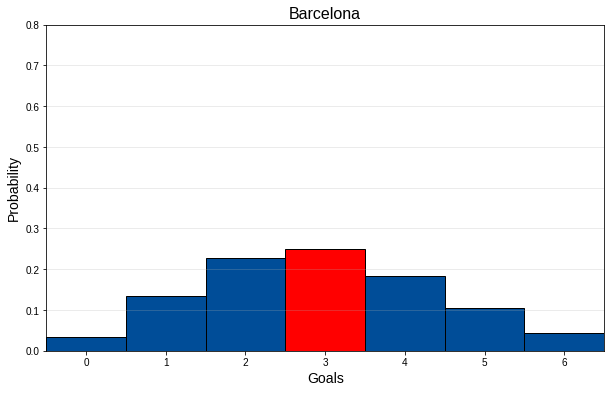

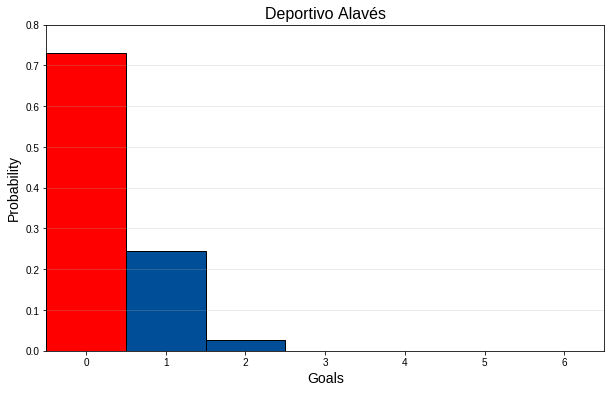

In [653]:
y = '2018' # Choose season
m = 0 # Choose match
h_goals, a_goals, *_ = outcome_prob(h_shots[y][m],a_shots[y][m])

max_val_tot = max(max(h_goals),max(a_goals))
max_val_h = max(h_goals)
max_val_a = max(a_goals)

fig, ax = plt.subplots(figsize=(10,6))
p = ax.hist(h_goals,bins=max_val_h,density=True,align='left',ec='k')
p[2][hts[y][m]].set_facecolor('r') # Colour the actual number of goals scored
ax.set(xlim=(-0.5,6.5),ylim=(0,0.8),xlabel='Goals',ylabel='Probability',title='{}'.format(ht[y][m]))
ax.grid(alpha=0.3,axis='y')
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
p = ax.hist(a_goals,bins=max_val_a,density=True,align='left',ec='k')
p[2][ats[y][m]].set_facecolor('r') # Colour the actual number of goals scored
ax.set(xlim=(-0.5,6.5),ylim=(0,0.8),xlabel='Goals',ylabel='Probability',title='{}'.format(at[y][m]))
ax.grid(alpha=0.3,axis='y')
plt.show()

In [405]:
results = {}
for year in years:
    year = str(year)
    result = []
    hgP = []
    agP = []
    hP = []
    aP = []
    dP = []
    result_pred = []
    barca_result = []
    barca_pred = []
    for m in range(len(scores[year])):
        ht = scores[year]['home_team'][m]
        at = scores[year]['away_team'][m]
        hts = scores[year]['home_score'][m]
        ats = scores[year]['away_score'][m]
        h_shots = shots[year][m][shots[year][m]['team'] == ht]['sb_xg'].values
        a_shots = shots[year][m][shots[year][m]['team'] == at]['sb_xg'].values

        if hts > ats:
            result.append('h')
        elif ats > hts:
            result.append('a')
        else:
            result.append('d')

        h_goals, a_goals, h, a, d = outcome_prob(h_shots,a_shots)
        hgP.append(Counter(h_goals).most_common(1)[0][0])
        agP.append(Counter(a_goals).most_common(1)[0][0])
        hP.append(h)
        aP.append(a)
        dP.append(d)

        if (h > a) and (h > d):
            result_pred.append('h')
        elif (a > h) and (a > d):
            result_pred.append('a')
        elif (d > h) and (d > a):
            result_pred.append('d')
        else:
            result_pred.append(None)

    results[year] = pd.DataFrame()
    results[year]['home_team'] = scores[year]['home_team']
    results[year]['away_team'] = scores[year]['away_team']
    results[year]['home_score'] = scores[year]['home_score']
    results[year]['away_score'] = scores[year]['away_score']
    results[year]['home_score_pred'] = hgP
    results[year]['away_score_pred'] = agP
    results[year]['home_win_prob'] = hP
    results[year]['away_win_prob'] = aP
    results[year]['draw_prob'] = dP
    results[year]['result'] = result
    results[year]['pred'] = result_pred

    barca_h_points = results[year][results[year]['home_team'] == 'Barcelona']['result'].replace({'h':3,'d':1,'a':0})
    barca_a_points = results[year][results[year]['away_team'] == 'Barcelona']['result'].replace({'h':0,'d':1,'a':3})
    barca_h_points_pred = results[year][results[year]['home_team'] == 'Barcelona']['pred'].replace({'h':3,'d':1,'a':0})
    barca_a_points_pred = results[year][results[year]['away_team'] == 'Barcelona']['pred'].replace({'h':0,'d':1,'a':3})
    
    # Create new columns for the points and predicted points for Barca
    results[year] = results[year].join(pd.concat([barca_h_points,barca_a_points]).sort_index().rename('barca_points'))
    results[year] = results[year].join(pd.concat([barca_h_points_pred,barca_a_points_pred]).sort_index().rename('barca_pred'))

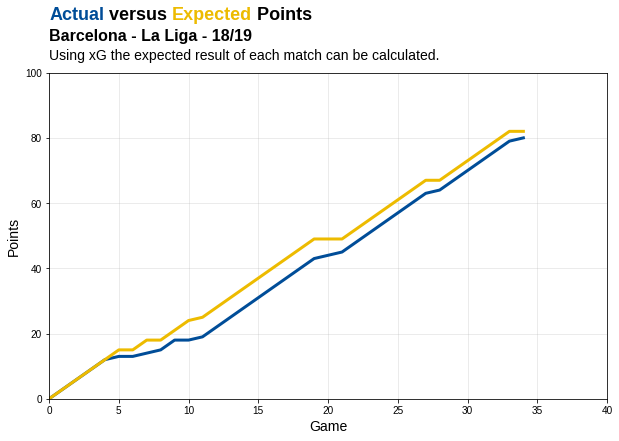

In [529]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.insert(results['2018']['barca_points'].values.cumsum(),0,0))
ax.plot(np.insert(results['2018']['barca_pred'].values.cumsum(),0,0))
ax.set(xlabel='Game',ylabel='Points',xlim=(0,40),ylim=(0,100))
ax.grid(alpha=0.3)
#ax.text(0.0,1.0,'')

axy = max(ax.get_ylim())
axx = min(ax.get_xlim())
htext(s = '<Actual> versus <Expected> Points',x = axx, y = axy+(axy*0.15),color = 'k', 
      highlight_colors = ['#004d98','#edbb00'],fontsize=18,string_weight = 'semibold',
      highlight_weights=['semibold'])
ax.text(axx,axy+(axy*0.10),'Barcelona - La Liga - 18/19',fontsize=16,fontweight='semibold')
ax.text(axx,axy+(axy*0.04),'Using xG the expected result of each match can be calculated.',fontsize=14)

plt.show()

In [442]:
barca_points_sum = np.array([results[str(year)]['barca_points'].sum() for year in years])
barca_pred_sum = np.array([results[str(year)]['barca_pred'].sum() for year in years])

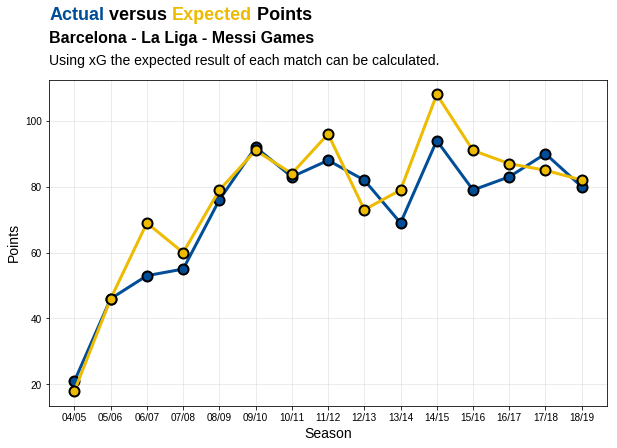

In [521]:
seasons = ['18/19','17/18','16/17','15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06','04/05']
ind = np.flip((np.arange(len(years))))
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, barca_points_sum,'-o',mec='k')
ax.plot(ind, barca_pred_sum,'-o',mec='k')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Points')
ax.grid(alpha=0.3)
#ax.text(0.0,1.0,'')

axy = max(ax.get_ylim())
axx = min(ax.get_xlim())
htext(s = '<Actual> versus <Expected> Points',x = axx, y = axy+(axy*0.15),color = 'k', 
      highlight_colors = ['#004d98','#edbb00'],fontsize=18,string_weight = 'semibold',
      highlight_weights=['semibold'])
ax.text(axx,axy+(axy*0.10),'Barcelona - La Liga - Messi Games',fontsize=16,fontweight='semibold')
ax.text(axx,axy+(axy*0.04),'Using xG the expected result of each match can be calculated.',fontsize=14)

plt.show()

In [482]:
draws = [len(results[str(year)][results[str(year)]['barca_points'] == 1]) for year in years]
draws_pred = [len(results[str(year)][results[str(year)]['barca_pred'] == 1]) for year in years]

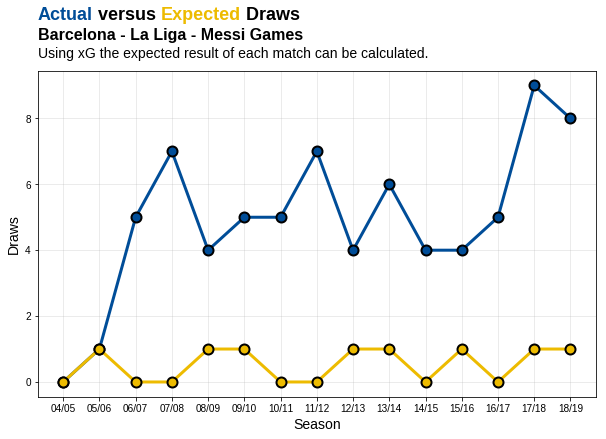

In [525]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, draws,'-o',mec='k')
ax.plot(ind, draws_pred,'-o',mec='k')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Draws')
ax.grid(alpha=0.3)
#ax.text(0.0,1.0,'')

axy = max(ax.get_ylim())
axx = min(ax.get_xlim())
htext(s = '<Actual> versus <Expected> Draws',x = axx, y = axy+(axy*0.15),color = 'k', 
      highlight_colors = ['#004d98','#edbb00'],fontsize=18,string_weight = 'semibold',
      highlight_weights=['semibold'])
ax.text(axx,axy+(axy*0.10),'Barcelona - La Liga - Messi Games',fontsize=16,fontweight='semibold')
ax.text(axx,axy+(axy*0.04),'Using xG the expected result of each match can be calculated.',fontsize=14)

plt.show()

Interestingly there are many more draws than predicted from xG.